In [1]:
#packages
import numpy as _np
import scipy.constants as _con
from scipy.integrate import quad
from scipy.integrate import trapz
import pandas as _pd
import matplotlib.pyplot as _plt

In [2]:
# Constants
k = _con.k  # Boltzmann constant (J/K)
c = _con.c  # Speed of light (m/s)
h = _con.h  # Planck's Constant (J-s)

In [3]:
# utility functions
def n_occ (T,v):
    """Photon mode occupation number of a black body of temperature T at frequency v"""
    return 1./(_np.exp(h*v/(k*T))-1)

def IBlackBody (T, v, pol=False):
    """Planck's Law spectral radiance - radiated power (in the normal direction) per steradian
    per square meter per Hertz at frequency v - for a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    polfactor = 1 if pol else 2
    return polfactor * h/(c**2)*(v**3)*n_occ(T,v)

def PBBSingleModed (T, v1=0, v2=_np.inf, pol=False):
    """Planck's Law radiative power received by an ideal single-moded
    receiver sensitive over frequency band [v1,v2] observing a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    (out,err) = quad(lambda v: IBlackBody(T,v,pol=pol)*(c/v)**2, v1, v2)
    return out

def NEP_photon (T,eta,v1=0,v2=_np.inf, pol=False, narrow=False):
    """Photon NEP [W/rtHz] for a noiseless detector observing temperature T
    with quantum efficiency eta over a frequency band [v1,v2].
    Defined with an integral to hander wider bands; faster with narrow=True."""
    polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
    if narrow:
        v0 = (v1+v2)/2.
        dv = (v2-v1)
        return _np.sqrt(2*polfactor)*h*v0*_np.sqrt(dv*eta*n_occ(T,v0)*(1+eta*n_occ(T,v0)))
    else:
        integrand = lambda v: eta*(h*v)**2*n_occ(T,v) + (eta*h*v*n_occ(T,v))**2
        # integrate and incorporate the factor of 2 from NEP definition
        return _np.sqrt(2*polfactor*quad(integrand,v1,v2)[0])

In [4]:
class amModel:
# am model
# Columns: f (GHz), tx , Tb (K), I (watt*cm-2*GHz-1*sr-1)
# tx: transmittance
# Tb: Planck brightness temperature (redundant with I)
# I: Spectral radiance (unpolarized)
    def __init__(self, filename, label=None):
        '''Initialize a new am model (code assumes we know the units!!!)'''
        self.atmo = _pd.read_csv(filename,header = None, sep=' ', names=['vGHz','tx','Tb','I'])
        self.atmo['n'] = self.atmo['I']*1e-5*c**2/(2*h*(self.atmo['vGHz']*1e9)**3)
        self.label=label
    def I(self,v):
        '''Atmospheric intensity as a function of frequency (W/m2/Hz/sr, dual-pol)'''
        return _np.interp(v/1e9,self.atmo['vGHz'],atmo['I'])*1e-5 # intensity in W/m2/Hz/sr (dual-pol)
    def n(self,v):
        '''Mode occupation number '''
        return self.I(v)*c**2/(2*h*v**3) # mode occupation number as a function of frequency
    def P(self,row,pol=False):
        """Returns the unobstructed single-moded power from the atmosphere model in a given band"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 2 if pol else 1 # Iatm is unpolarized, so we divide by 2 for single-pol
        temp = self.atmo[(self.atmo['vGHz']>=(row['v']-row['dv']/2)/1e9) & 
                         (self.atmo['vGHz']<(row['v']+row['dv']/2)/1e9)]
        return trapz(temp['I']*1e-5,x=temp['vGHz']*1e9)/polfactor *(row['lambda']**2)
    def NEP(self,row,eta,pol=False):
        """Atmospheric NEP associated with a given band observed with efficiency eta"""
        # implemented numerically, assuming that the data file is sampled much more finely than we need
        polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
        temp = self.atmo[(self.atmo['vGHz']>=(row['v']-row['dv']/2)/1e9) & 
                         (self.atmo['vGHz']<(row['v']+row['dv']/2)/1e9)]
        return _np.sqrt( polfactor * trapz( 
            (h*temp['vGHz']*1e9)**2*eta*temp['n'] + (eta*h*temp['vGHz']*1e9*temp['n'])**2,
            x=temp['vGHz']*1e9))

In [5]:
# define the warm and cold optics
# Warm primary mirror, visible only through grating
Tprimary = 250. # Kelvin
epsPrimary = 0.025 # Emissivity of the primary
etaPrimary = 0.15 # Efficiency to the primary (and sky)
# Cold optics box, assumed visible across full band
#Toptics = 4.2 # Kelvin
Toptics = 3.4 # Kelvin
epsOptics = 1.0 # Emissivity of the cold optics
etaOptics = 1.0 # Efficiency to the cold optics (over-estimate?)
NmodesOptics= 1 # Number of horn waveguide modes terminating on the optics box (not the sky)
pol=False # polarization-insensitive

In [6]:
# define the spectrometer bands in wavelength and frequency space
# SWcam
npix_spectral_SW = 63*2 # hex-packed 64x63, so 126 distinct bands
lambda_min = 240e-6 # meters
lambda_max = 317e-6 # meters
vMin = c/lambda_max
vMax = c/lambda_min
wvl_edge = _np.logspace(_np.log10(lambda_min),_np.log10(lambda_max),
                  num=npix_spectral_SW+1)
nu_edgeSW = c/wvl_edge
wvlSW = (wvl_edge[1:] + wvl_edge[:-1])/2.
# LWcam
npix_spectral_LW = 63*2 # hex-packed 51x63, so 126 distinct bands
lambda_min = 317e-6 # meters
lambda_max = 420e-6 # meters
vMin = c/lambda_max
vMax = c/lambda_min
wvl_edge = _np.logspace(_np.log10(lambda_min),_np.log10(lambda_max),
                  num=npix_spectral_LW+1)
nu_edge = c/wvl_edge
nu_edgeLW = c/wvl_edge
wvlLW = (wvl_edge[1:] + wvl_edge[:-1])/2.
# combination
wvl = _np.append(wvlSW,wvlLW)
nu_edge = _np.append(nu_edgeSW,nu_edgeLW)
bands = _pd.DataFrame(data=wvl,columns=['lambda'])
bands['v']=c/bands['lambda']
bands['dv']=-_np.append(_np.diff(nu_edgeSW),_np.diff(nu_edgeLW))

In [7]:
# optical loading model
# Atmosphere
atmo37 = amModel('Antarctic_DJF_37km_0_2000_10M_45_1.out',label='37km')
atmo40 = amModel('Antarctic_DJF_40km_0_2000_10M_45_1.out',label='40km')
atmo = atmo37 # pick one for the plots
bands['Patm'] = etaPrimary*bands.apply(atmo.P,axis=1,pol=pol)
# Warm optics: loads each channel through its spectrometer band (narrow band approximation)
bands['Pprimary'] = epsPrimary*etaPrimary*IBlackBody(Tprimary,bands['v'],pol=pol)*bands['dv']*bands['lambda']**2
# Cold optics: loads all channels equally (cold-ward of spectrometer)
bands['Poptics'] = NmodesOptics*epsOptics*etaOptics*PBBSingleModed(Toptics, v1=vMin, v2=vMax, pol=pol)
# Put it all together
bands['P'] = bands['Pprimary'] + bands['Poptics'] + bands['Patm']

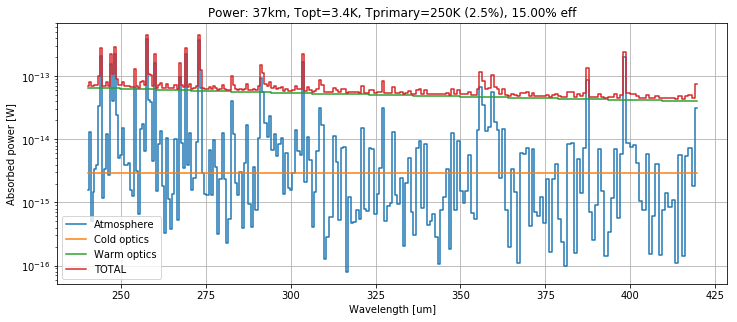

In [8]:
# plot the optical loads
_plt.figure(figsize=(12,4.8))
ax=_plt.step(bands['lambda']*1e6,bands['Patm'],where='mid',label='Atmosphere')
_plt.step(bands['lambda']*1e6,bands['Poptics'],where='mid',label='Cold optics')
_plt.step(bands['lambda']*1e6,bands['Pprimary'],where='mid',label='Warm optics')
_plt.step(bands['lambda']*1e6,bands['P'],where='mid',label='TOTAL')
_plt.gca().set_yscale("log", nonposy='clip')
_plt.grid()
_plt.xlabel('Wavelength [um]')
_plt.ylabel('Absorbed power [W]')
_plt.title('Power: %s, Topt=%.1fK, Tprimary=%dK (%.1f%%), %.2f%% eff'%(
    atmo.label, Toptics,Tprimary,epsPrimary*100,etaPrimary*100))
_plt.legend()

In [9]:
# noise model
bands['NEPatm'] = bands.apply(lambda row: atmo.NEP(row,eta=etaPrimary,pol=pol),axis=1)
#bands['NEPprimary'] = bands.apply(lambda row: NEP_photon_from_power(
#    row['Pprimary'],row['v'],row['dv'],pol=pol),axis=1)
bands['NEPprimary'] = bands.apply(lambda row: NEP_photon(Tprimary,etaPrimary*epsPrimary,v1=row['v']-row['dv']/2,
                                                         v2=row['v']+row['dv']/2, pol=pol,narrow=True),axis=1)
bands['NEPoptics'] = NEP_photon(Toptics,etaOptics*epsOptics,v1=vMin,v2=vMax, pol=pol)*_np.sqrt(NmodesOptics)
bands['NEP'] = _np.sqrt(bands['NEPprimary']**2 + bands['NEPoptics']**2 + bands['NEPatm']**2)

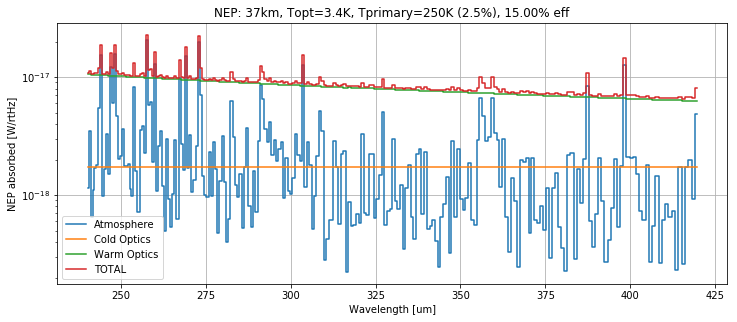

In [10]:
# plot the optical NEPs
_plt.figure(figsize=(12,4.8))
_plt.step(bands['lambda']*1e6,bands['NEPatm'],where='mid',label='Atmosphere')
_plt.step(bands['lambda']*1e6,bands['NEPoptics'],where='mid',label='Cold Optics')
_plt.step(bands['lambda']*1e6,bands['NEPprimary'],where='mid',label='Warm Optics')
_plt.step(bands['lambda']*1e6,bands['NEP'],where='mid',label='TOTAL')
_plt.gca().set_yscale("log", nonposy='clip')
_plt.grid()
_plt.xlabel('Wavelength [um]')
_plt.ylabel('NEP absorbed [W/rtHz]')
_plt.title('NEP: %s, Topt=%.1fK, Tprimary=%dK (%.1f%%), %.2f%% eff'%(
    atmo.label, Toptics,Tprimary,epsPrimary*100,etaPrimary*100))
_plt.legend()